<a href="https://colab.research.google.com/github/AlexandraCordeiro/aesthetics-classification/blob/main/experiments_regression_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

In [ ]:
!nvidia-smi

Sun Sep  8 17:07:18 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P0             32W /  250W |   15531MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Git Repo

- https://github.com/AlexandraCordeiro/aesthetics-classification

# Funções úteis

- ``` download_dataset ```

- ``` extract_zip_folder ```

- ``` get_images_and_csv_file ```

- ``` show_transformed_img ```

- ``` train_test_split ```

- ``` create_dataloaders ```

- ``` train_model_loop ```

- ``` CustomDataset ```

- ``` plot_loss_values ```

- ``` run_experiment ```

- ```  input_size_folder ```

In [ ]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")

def download_dataset(url, data_path, zip_name):
  if data_path.is_dir():
    print(f"{data_path}")
  else:
    print(f"{data_path} create new folder")
    data_path.mkdir(parents=True, exist_ok=True)

  with open(data_path / zip_name, "wb") as f:
    request = requests.get(url)
    print("Downloading data...")
    f.write(request.content)

In [ ]:
# extract zip folder
import io

def extract_zip_folder(url, data_path):
  response = requests.get(url)
  if response.status_code == 200:
      with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
          zip_ref.extractall(data_path)
  else:
      print("Failed to download the file.")

In [ ]:
import pandas as pd

def get_images_and_csv_file(data_path, dataset_name):
  # images
  dataset_dir = data_path / dataset_name
  images_all = list(dataset_dir.glob('*.png'))

  # csv file
  csv_file = list(dataset_dir.glob('*.csv'))

  return images_all, csv_file

In [ ]:
from PIL import Image
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset
import numpy as np

# TRANSFORM

transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# CUSTOM DATASET
class CustomDataset(Dataset):
  def __init__(self, image_paths, transform=None):
    self.image_paths = image_paths
    self.transform = transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image_filepath = self.image_paths[idx]
    image = Image.open(image_filepath).convert('RGB')
    label = np.float64(f"{image_filepath}".split('/')[2].split('-')[-1].split('.png')[0])
    label = torch.tensor(label, dtype=torch.float32)

    if self.transform:
      image = self.transform(image)

    return image, label

In [ ]:
import matplotlib.pyplot as plt

def show_transformed_img(image):
  print(f"shape: {image.shape}")
  plt.imshow(image.permute(1, 2, 0))
  plt.show()

https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss

In [ ]:
def train_test_split(dataset, train_size):
  train_data, test_data = torch.utils.data.random_split(dataset, [train_size, 1 - train_size])
  return train_data, test_data

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

def create_dataloaders(train_data, test_data):

  BATCH_SIZE = 32
  TRAIN_SPLIT = 0.75
  VAL_SPLIT = 1- TRAIN_SPLIT

  total_samples = len(train_data)
  num_train_samples = int(total_samples * TRAIN_SPLIT)
  num_val_samples = total_samples - num_train_samples

  (train_data, val_data) = random_split(train_data,
                                  [num_train_samples, num_val_samples],
                                  generator=torch.Generator())

  train_dataloader = DataLoader(dataset=train_data,
                                batch_size=BATCH_SIZE,
                                shuffle=True)

  test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

  val_dataloader = DataLoader(dataset=val_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

  print(f"Dataloaders: {train_dataloader, test_dataloader}")
  print(f"Length train_dataloader: {len(train_dataloader)}")
  print(f"Length test_dataloader: {len(test_dataloader)}")
  print(f"Length test_dataloader: {len(val_dataloader)}")
  return train_dataloader, test_dataloader, val_dataloader



In [ ]:
class ModelMetrics():
  def __init__(self):
    self.train_loss_values = []
    self.val_loss_values = []
    self.test_loss_values = []

def train(model: torch.nn.Module,
          train_data_loader: torch.utils.data.DataLoader,
          val_data_loader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device=device):

    train_loss, val_loss = 0, 0

    model.train()

    for batch, (X, y) in enumerate(train_data_loader):
      X, y = X.to(device), y.to(device)

      y_pred = torch.squeeze(model(X))

      loss = loss_fn(y_pred, y)
      train_loss += loss
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_loss /= len(train_data_loader)
    # validation
    with torch.no_grad():
      # evaluation mode
      model.eval()

      for (X, y) in val_data_loader:
        (X, y) = (X.to(device), y.to(device))

        pred = torch.squeeze(model(X))
        val_loss += loss_fn(pred, y)

    val_loss /= len(val_data_loader)

    print(f"Train Loss: {train_loss:.5f}")
    print(f"Validation Loss: {val_loss:.5f}")

    return train_loss, val_loss


def test(model: torch.nn.Module,
         data_loader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
         device: torch.device=device):

    test_loss = 0

    model.eval()
    model.to(device)

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            test_pred = torch.squeeze(model(X))

            test_loss += loss_fn(test_pred, y)

        test_loss /= len(data_loader)

    print(f"Test Loss: {test_loss:.5f}")
    return test_loss



In [ ]:
from tqdm.auto import tqdm

def train_model_loop(epochs, model, model_metrics, train_dataloader, val_dataloader, test_dataloader, loss_fn, optimizer, device):

  for epoch in tqdm(range(epochs)):
      print(f"Epoch: {epoch}")

      # train
      train_loss, val_loss = train(model=model,
                                                        train_data_loader=train_dataloader,
                                                        val_data_loader=val_dataloader,
                                                        loss_fn=loss_fn,
                                                        optimizer=optimizer,
                                                        device=device)

      # update model metrics
      model_metrics.train_loss_values.append(train_loss)
      model_metrics.val_loss_values.append(val_loss)

      # test
      test_loss = test(model=model,
                                              data_loader=test_dataloader,
                                              loss_fn=loss_fn,
                                              optimizer=optimizer,
                                              device=device)
      # update model metrics
      model_metrics.test_loss_values.append(test_loss)

      print("-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+")

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_values(model_metrics, architecture, results_folder_dir, title=None):
  plt.rcParams['figure.dpi'] = 300
  plt.rcParams['savefig.dpi'] = 300
  plt.rcParams['axes.facecolor']='white'
  plt.plot(torch.tensor(model_metrics.train_loss_values, device='cpu'), label='Train Loss')
  plt.plot(torch.tensor(model_metrics.val_loss_values, device='cpu'), label='Val Loss')
  plt.plot(torch.tensor(model_metrics.test_loss_values, device='cpu'), label='Test Loss')
  plt.title(f'Loss Values: {title or ""} ({architecture})')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  new_folder = results_folder_dir / title

  if not new_folder.is_dir():
    new_folder.mkdir()

  plt.savefig(new_folder / architecture)
  # plt.show()



In [ ]:
from pathlib import Path
models_dir = Path("models")

def save_model(models_dir, model_name, model):

  if models_dir.is_dir() == False:
    models_dir.mkdir()

  new_dir = models_dir / model_name
  torch.save(obj=model.state_dict(), f=new_dir)


In [ ]:
from torch import nn

def run_experiment(dataset_name, url, data_path, transform, epochs, lr, model_architecture, device):

  # download and extract dataset
  download_dataset(url, data_path, f'{dataset_name}.zip')
  extract_zip_folder(url, data_path)

  # extract images and csv file
  images_all, csv_file = get_images_and_csv_file(data_path, dataset_name)
  df = pd.read_csv(csv_file[0])
  # print(df)

  # create simulacra dataset
  curated_dataset = CustomDataset(image_paths=images_all, transform=transform)


  # split train/test data
  train_data, test_data = train_test_split(curated_dataset, 0.7)


  # create dataloaders
  train_dataloader, test_dataloader, val_dataloader = create_dataloaders(train_data, test_data)

  # model metrics
  model_metrics = ModelMetrics()

  # Model: DenseNet
  if model_architecture == 'dense_net_121':
    model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', weights=None)
    model.classifier = nn.Sequential(
        nn.Linear(1024, 1000),
        nn.Linear(1000, 512),
        nn.Linear(512, 100),
        nn.Linear(100, 1)
    )
    model.to(device)
  if model_architecture == 'res_net_18':
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)
    model.fc = nn.Sequential(
        nn.Linear(512, 100),
        nn.Linear(100, 1)
      )
    model.to(device)

  if model_architecture == 'vgg19_bn':
    model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn', weights=None)
    model.classifier.append(nn.Linear(1000, 512))
    model.classifier.append(nn.Linear(512, 100))
    model.classifier.append(nn.Linear(100, 1))
    model.to(device)

  # mudar a última parte da rede neuronal


  # loss & optimizer
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.Adam(params=model.parameters(),
                              lr=lr)

  # loop
  train_model_loop(epochs=epochs,
                  model=model,
                  model_metrics=model_metrics,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  val_dataloader=val_dataloader,
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  device=device)

  # plot results
  experiments_plots = Path('experiments_plots')

  if experiments_plots.is_dir() is False:
    experiments_plots.mkdir(parents=True, exist_ok=True)

  plot_loss_values(model_metrics, model_architecture, experiments_plots, dataset_name)

  # save model
  save_model(models_dir, f'{dataset_name}_{model_architecture}_lr_{lr}', model)

  return model

In [ ]:
!pip install pyopenssl

# Run Experiments

In [ ]:
VGG_19 = 'vgg19_bn'
DENSE_NET_121 = 'dense_net_121'
RES_NET_18 = 'res_net_18'

simulacra_url = "https://github.com/AlexandraCordeiro/aesthetics-classification/releases/download/v1-dataset-simulacra/simulacra_curated_dataset.zip"
laion_url = "https://github.com/AlexandraCordeiro/aesthetics-classification/releases/download/v1-dataset-laion/laion_curated_dataset.zip"
simulacra_and_laion_url = "https://github.com/AlexandraCordeiro/aesthetics-classification/releases/download/v1-simulacra-laion-dataset/simulacra_and_laion_curated_dataset.zip"

## simulacra curated dataset

### dense net

data
Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fa80e2e6230>, <torch.utils.data.dataloader.DataLoader object at 0x7fa80e2e5510>)
Length train_dataloader: 36
Length test_dataloader: 21
Length test_dataloader: 12


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 1.94249
Validation Loss: 0.08667
Test Loss: 0.08973
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 1
Train Loss: 0.05572
Validation Loss: 0.04241
Test Loss: 0.04688
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 2
Train Loss: 0.04007
Validation Loss: 0.03784
Test Loss: 0.03900
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 3
Train Loss: 0.03327
Validation Loss: 0.05722
Test Loss: 0.04973
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 4
Train Loss: 0.03128
Validation Loss: 0.06911
Test Loss: 0.07164
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 5
Train Loss: 0.02925
Validation Loss: 0.03237
Test Loss: 0.03399
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 6
Train Loss: 0.02170
Validation Loss: 0.04053
Test Loss: 0.03630
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 7
Train Loss: 0.02078
Validation Loss: 0.02896
Test Loss: 0.02612
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 8
Train Loss: 0.02176
Validation Loss: 0.02738
Test Loss: 0.02469
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 9
Train Loss: 0.01906
Validation Loss: 

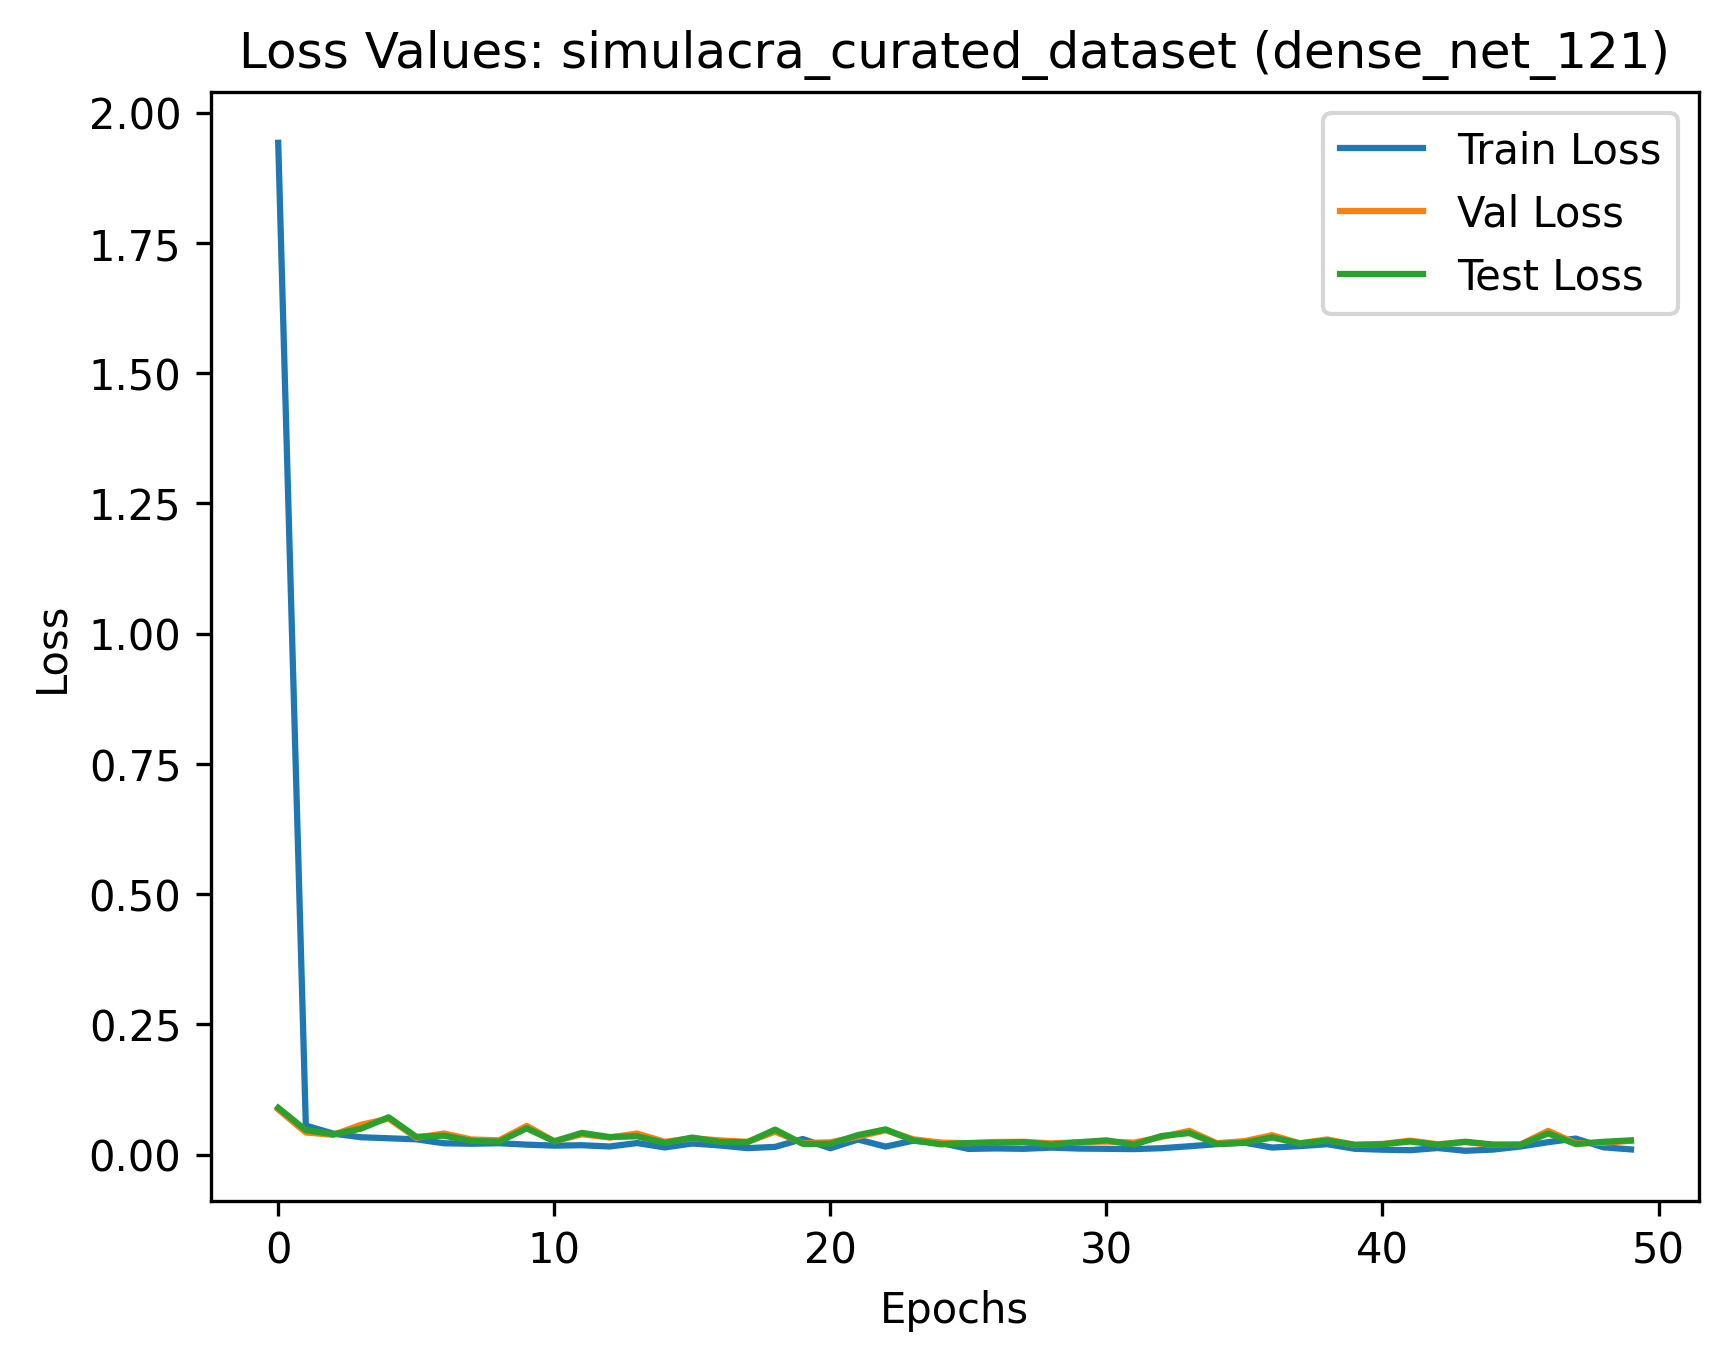

In [ ]:
# dense net
simulacra_model_dense_net = run_experiment(dataset_name="simulacra_curated_dataset",
               url=simulacra_url,
               data_path=data_path,
               transform=transform,
               epochs=50,
               lr=0.0001,
               model_architecture=DENSE_NET_121,
               device=device)

### res net

data
Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fa83b749450>, <torch.utils.data.dataloader.DataLoader object at 0x7fa83b74b7c0>)
Length train_dataloader: 36
Length test_dataloader: 21
Length test_dataloader: 12


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 1.54997
Validation Loss: 0.20049
Test Loss: 0.21764
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 1
Train Loss: 0.10357
Validation Loss: 0.05083
Test Loss: 0.05792
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 2
Train Loss: 0.04261
Validation Loss: 0.03259
Test Loss: 0.03539
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 3
Train Loss: 0.02908
Validation Loss: 0.03278
Test Loss: 0.03738
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 4
Train Loss: 0.02967
Validation Loss: 0.03480
Test Loss: 0.03604
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 5
Train Loss: 0.02296
Validation Loss: 0.02765
Test Loss: 0.02643
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 6
Train Loss: 0.01524
Validation Loss: 0.03234
Test Loss: 0.02988
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 7
Train Loss: 0.01415
Validation Loss: 0.02410
Test Loss: 0.02217
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 8
Train Loss: 0.01282
Validation Loss: 0.02784
Test Loss: 0.02549
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 9
Train Loss: 0.01214
Validation Loss: 

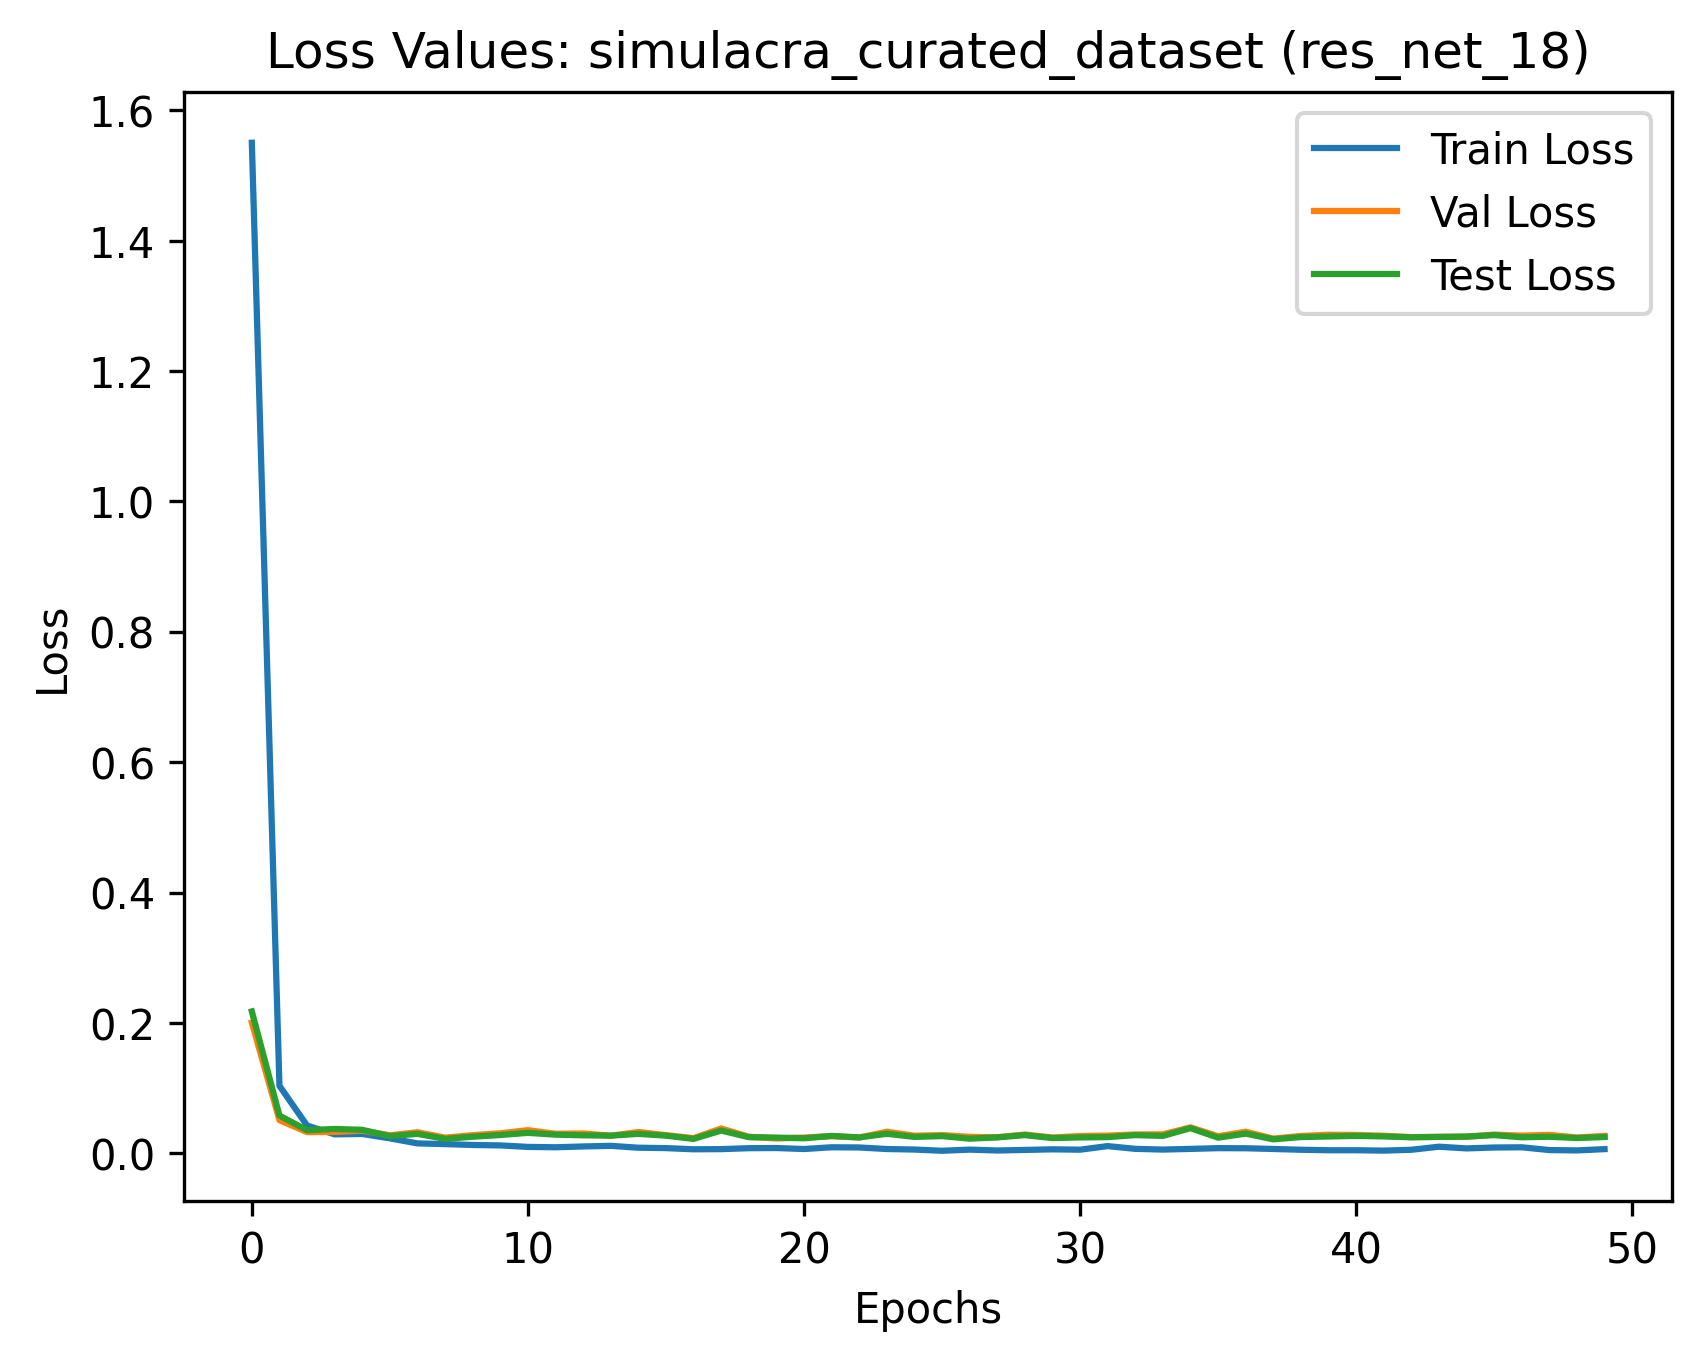

In [ ]:
# res net
simulacra_model_res_net = run_experiment(dataset_name="simulacra_curated_dataset",
               url=simulacra_url,
               data_path=data_path,
               transform=transform,
               epochs=50,
               lr=0.0001,
               model_architecture=RES_NET_18,
               device=device)

### vgg

data
Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fa80e3b3d60>, <torch.utils.data.dataloader.DataLoader object at 0x7fa83b74ba30>)
Length train_dataloader: 36
Length test_dataloader: 21
Length test_dataloader: 12


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 0.82698
Validation Loss: 0.97239
Test Loss: 1.03318
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 1
Train Loss: 0.25645
Validation Loss: 0.30238
Test Loss: 0.31136
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 2
Train Loss: 0.16455
Validation Loss: 0.31757
Test Loss: 0.32351
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 3
Train Loss: 0.16363
Validation Loss: 0.53472
Test Loss: 0.54659
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 4
Train Loss: 0.10968
Validation Loss: 0.41810
Test Loss: 0.42978
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 5
Train Loss: 0.10532
Validation Loss: 0.27095
Test Loss: 0.25321
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 6
Train Loss: 0.12568
Validation Loss: 0.39095
Test Loss: 0.39884
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 7
Train Loss: 0.09885
Validation Loss: 0.27448
Test Loss: 0.27523
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 8
Train Loss: 0.11605
Validation Loss: 0.17503
Test Loss: 0.17613
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 9
Train Loss: 0.14850
Validation Loss: 

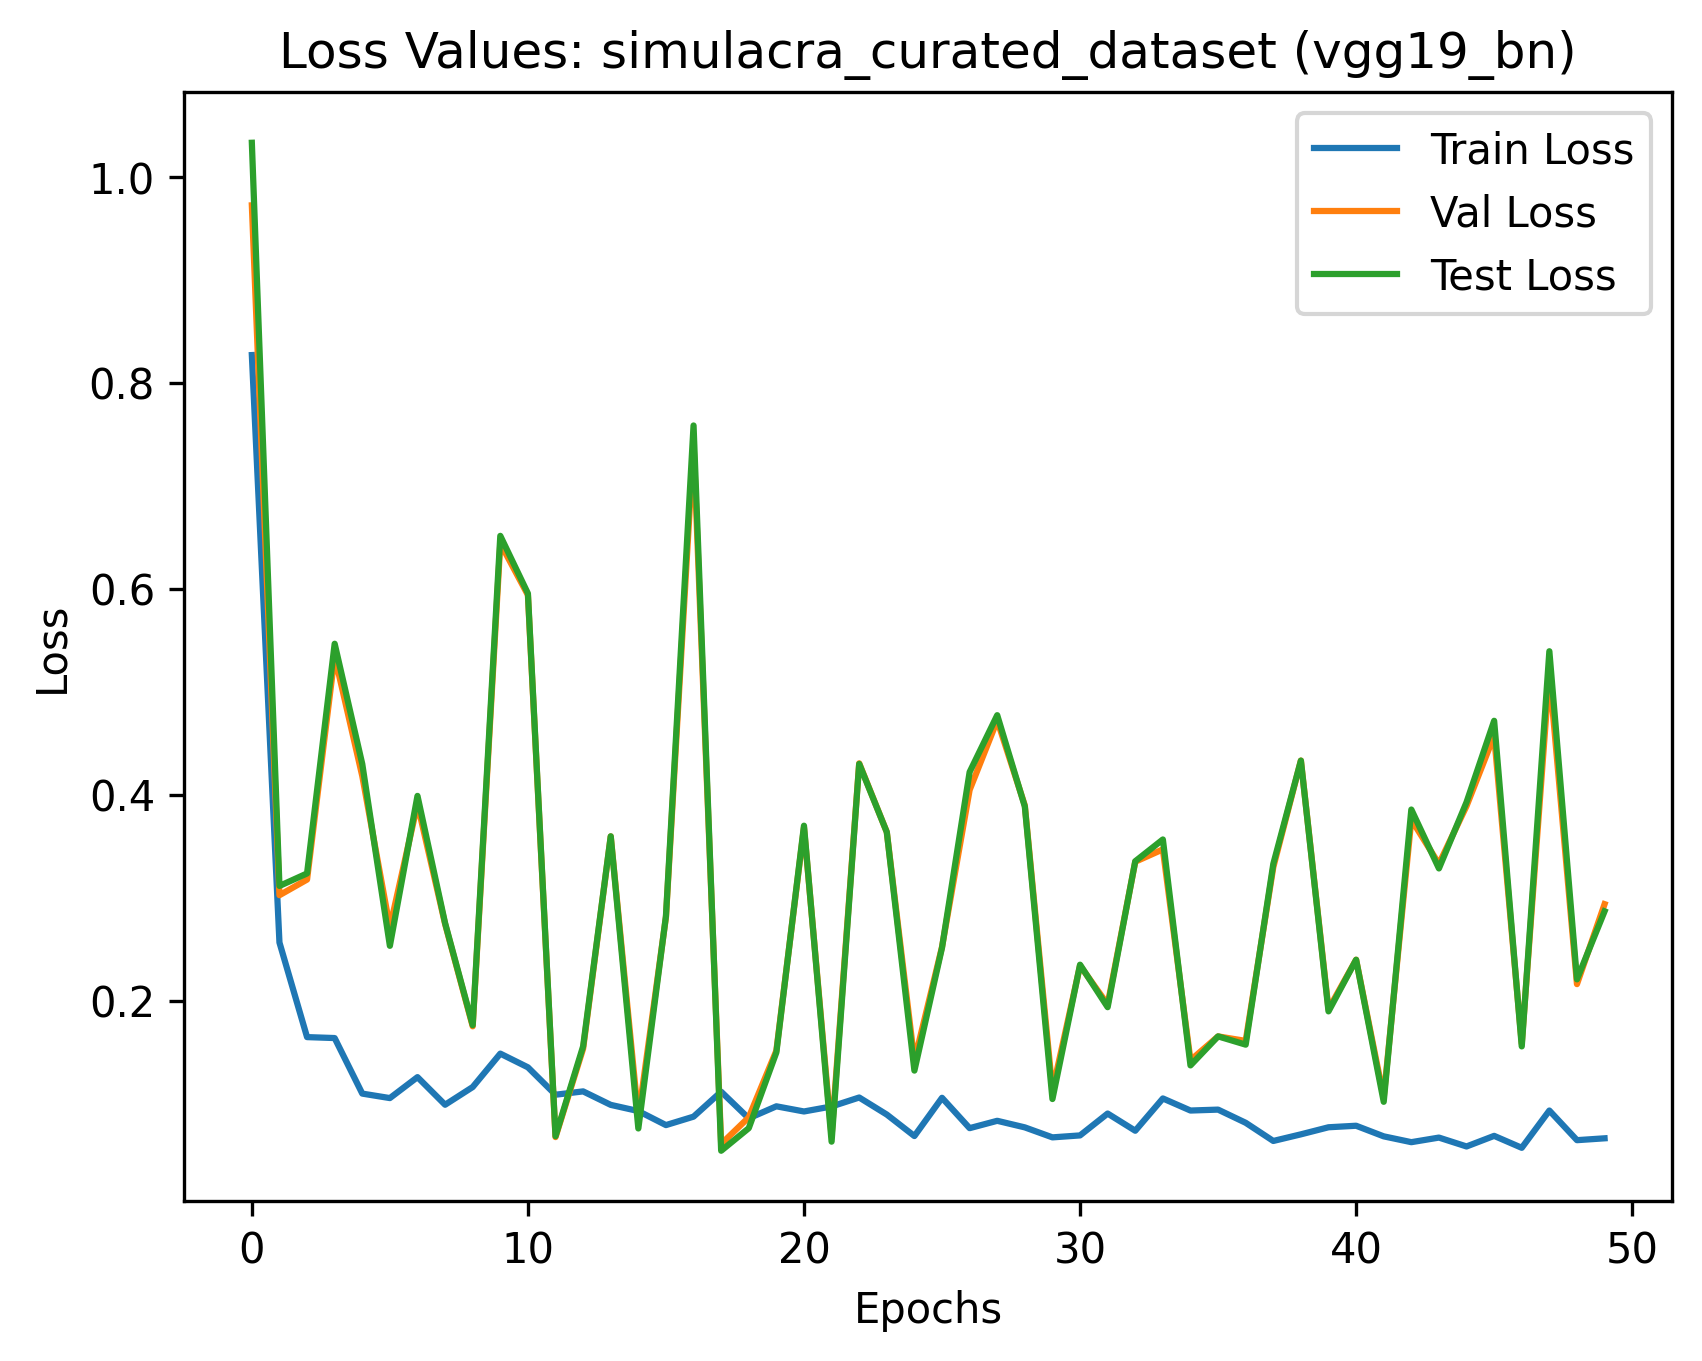

In [ ]:
# vgg
simulacra_model_vgg = run_experiment(dataset_name="simulacra_curated_dataset",
               url=simulacra_url,
               data_path=data_path,
               transform=transform,
               epochs=50,
               lr=0.0001,
               model_architecture=VGG_19,
               device=device)

## laion curated dataset

### dense net

In [ ]:
import time
time.sleep(5)

data
Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fa828951390>, <torch.utils.data.dataloader.DataLoader object at 0x7fa828952350>)
Length train_dataloader: 37
Length test_dataloader: 21
Length test_dataloader: 13


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 2.19741
Validation Loss: 0.13413
Test Loss: 0.21371
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 1
Train Loss: 0.10879
Validation Loss: 0.05382
Test Loss: 0.06466
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 2
Train Loss: 0.07024
Validation Loss: 0.06199
Test Loss: 0.08263
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 3
Train Loss: 0.05660
Validation Loss: 0.03709
Test Loss: 0.04529
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 4
Train Loss: 0.08078
Validation Loss: 0.10029
Test Loss: 0.10063
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 5
Train Loss: 0.06025
Validation Loss: 0.04239
Test Loss: 0.04821
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 6
Train Loss: 0.06686
Validation Loss: 0.03221
Test Loss: 0.04112
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 7
Train Loss: 0.05523
Validation Loss: 0.02920
Test Loss: 0.03492
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 8
Train Loss: 0.05318
Validation Loss: 0.07435
Test Loss: 0.08416
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 9
Train Loss: 0.04359
Validation Loss: 

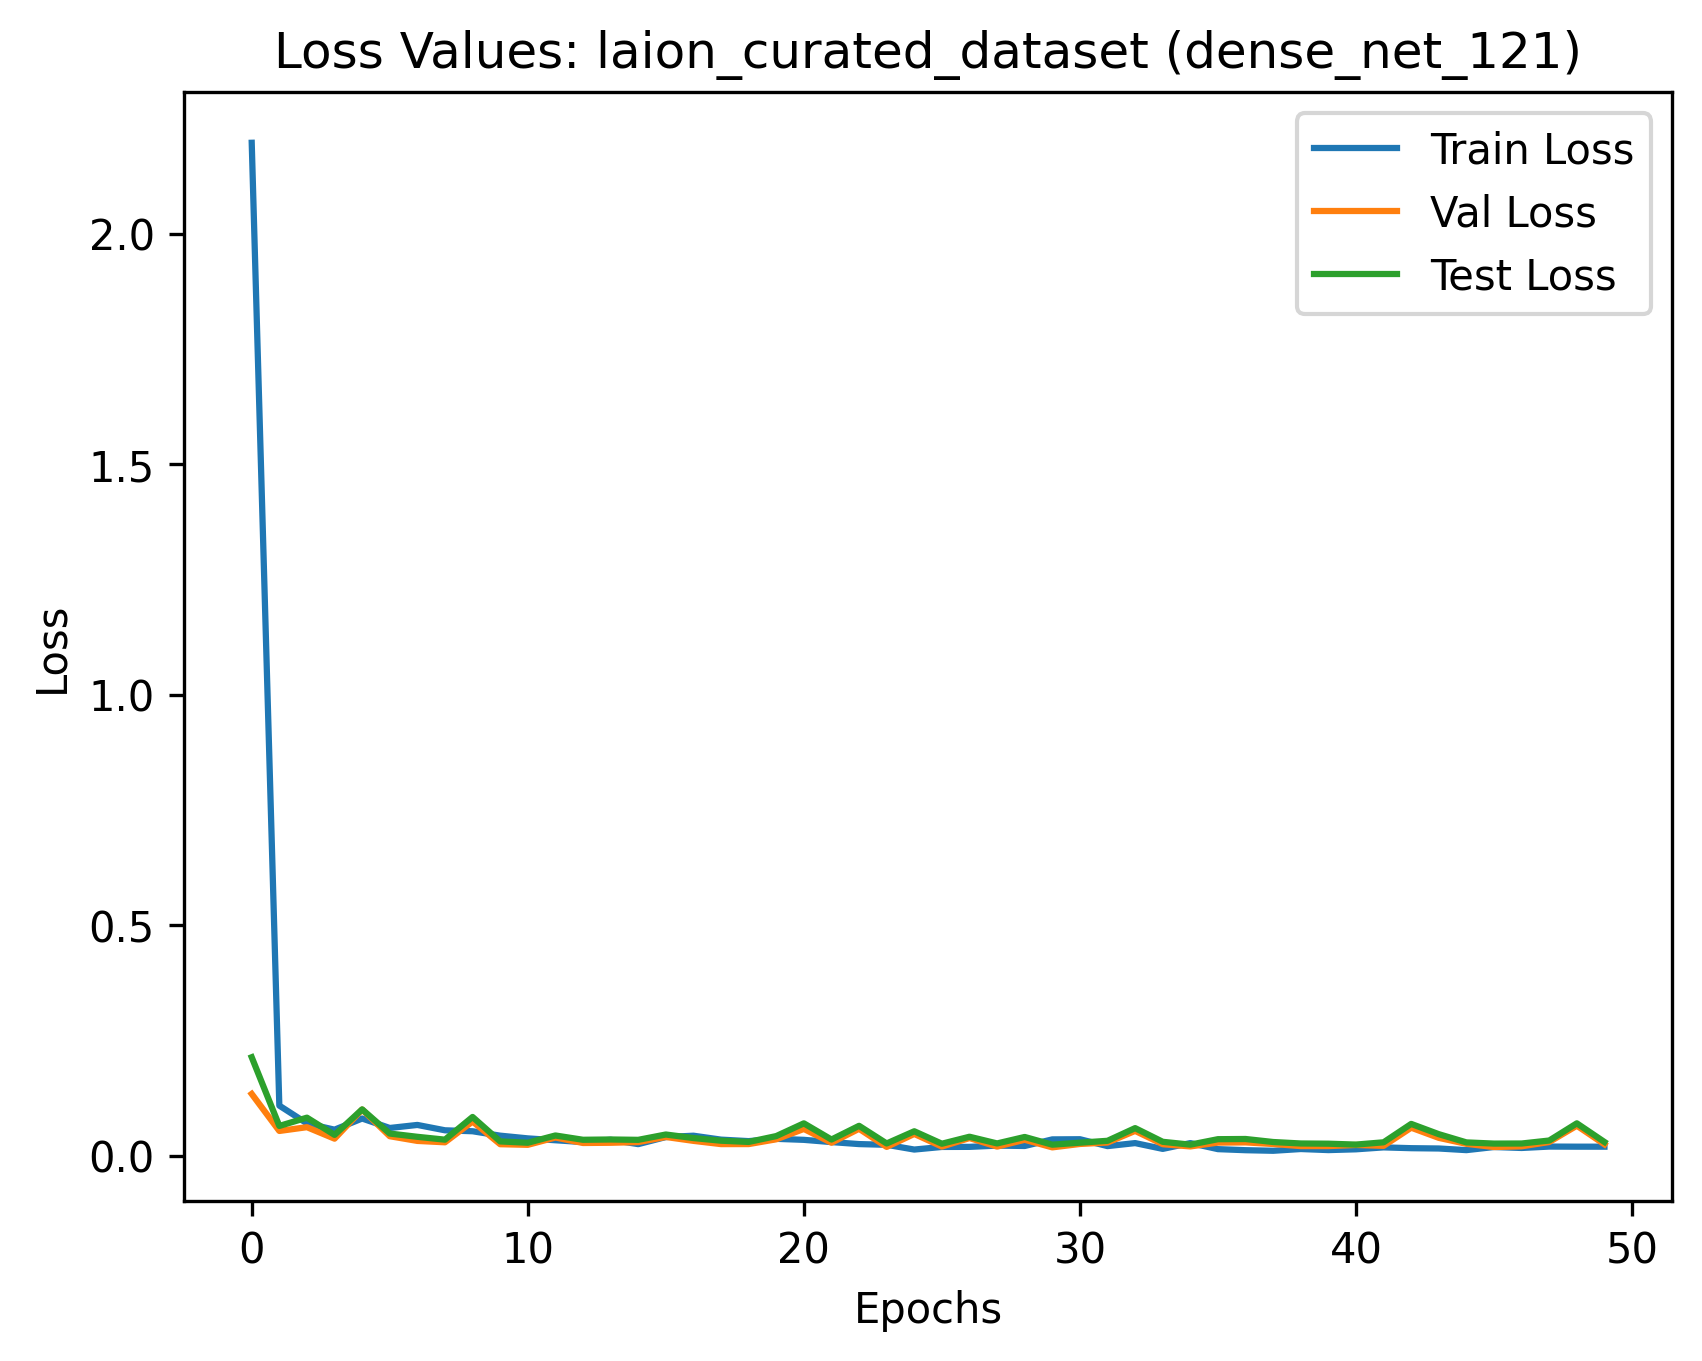

In [ ]:
# dense net
laion_dense_net = run_experiment(dataset_name="laion_curated_dataset",
               url=laion_url,
               data_path=data_path,
               transform=transform,
               epochs=50,
               lr=0.0001,
               model_architecture=DENSE_NET_121,
               device=device)

In [ ]:
time.sleep(5)

### res net

data
Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fa80dc63670>, <torch.utils.data.dataloader.DataLoader object at 0x7fa80dc63640>)
Length train_dataloader: 37
Length test_dataloader: 21
Length test_dataloader: 13


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 2.86245
Validation Loss: 0.44124
Test Loss: 0.41839
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 1
Train Loss: 0.14985
Validation Loss: 0.08931
Test Loss: 0.08241
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 2
Train Loss: 0.07857
Validation Loss: 0.05770
Test Loss: 0.05998
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 3
Train Loss: 0.05643
Validation Loss: 0.05198
Test Loss: 0.05303
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 4
Train Loss: 0.04861
Validation Loss: 0.05838
Test Loss: 0.05342
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 5
Train Loss: 0.03507
Validation Loss: 0.04814
Test Loss: 0.04865
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 6
Train Loss: 0.04335
Validation Loss: 0.07197
Test Loss: 0.07062
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 7
Train Loss: 0.05557
Validation Loss: 0.03638
Test Loss: 0.03761
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 8
Train Loss: 0.04666
Validation Loss: 0.03828
Test Loss: 0.03870
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 9
Train Loss: 0.02753
Validation Loss: 

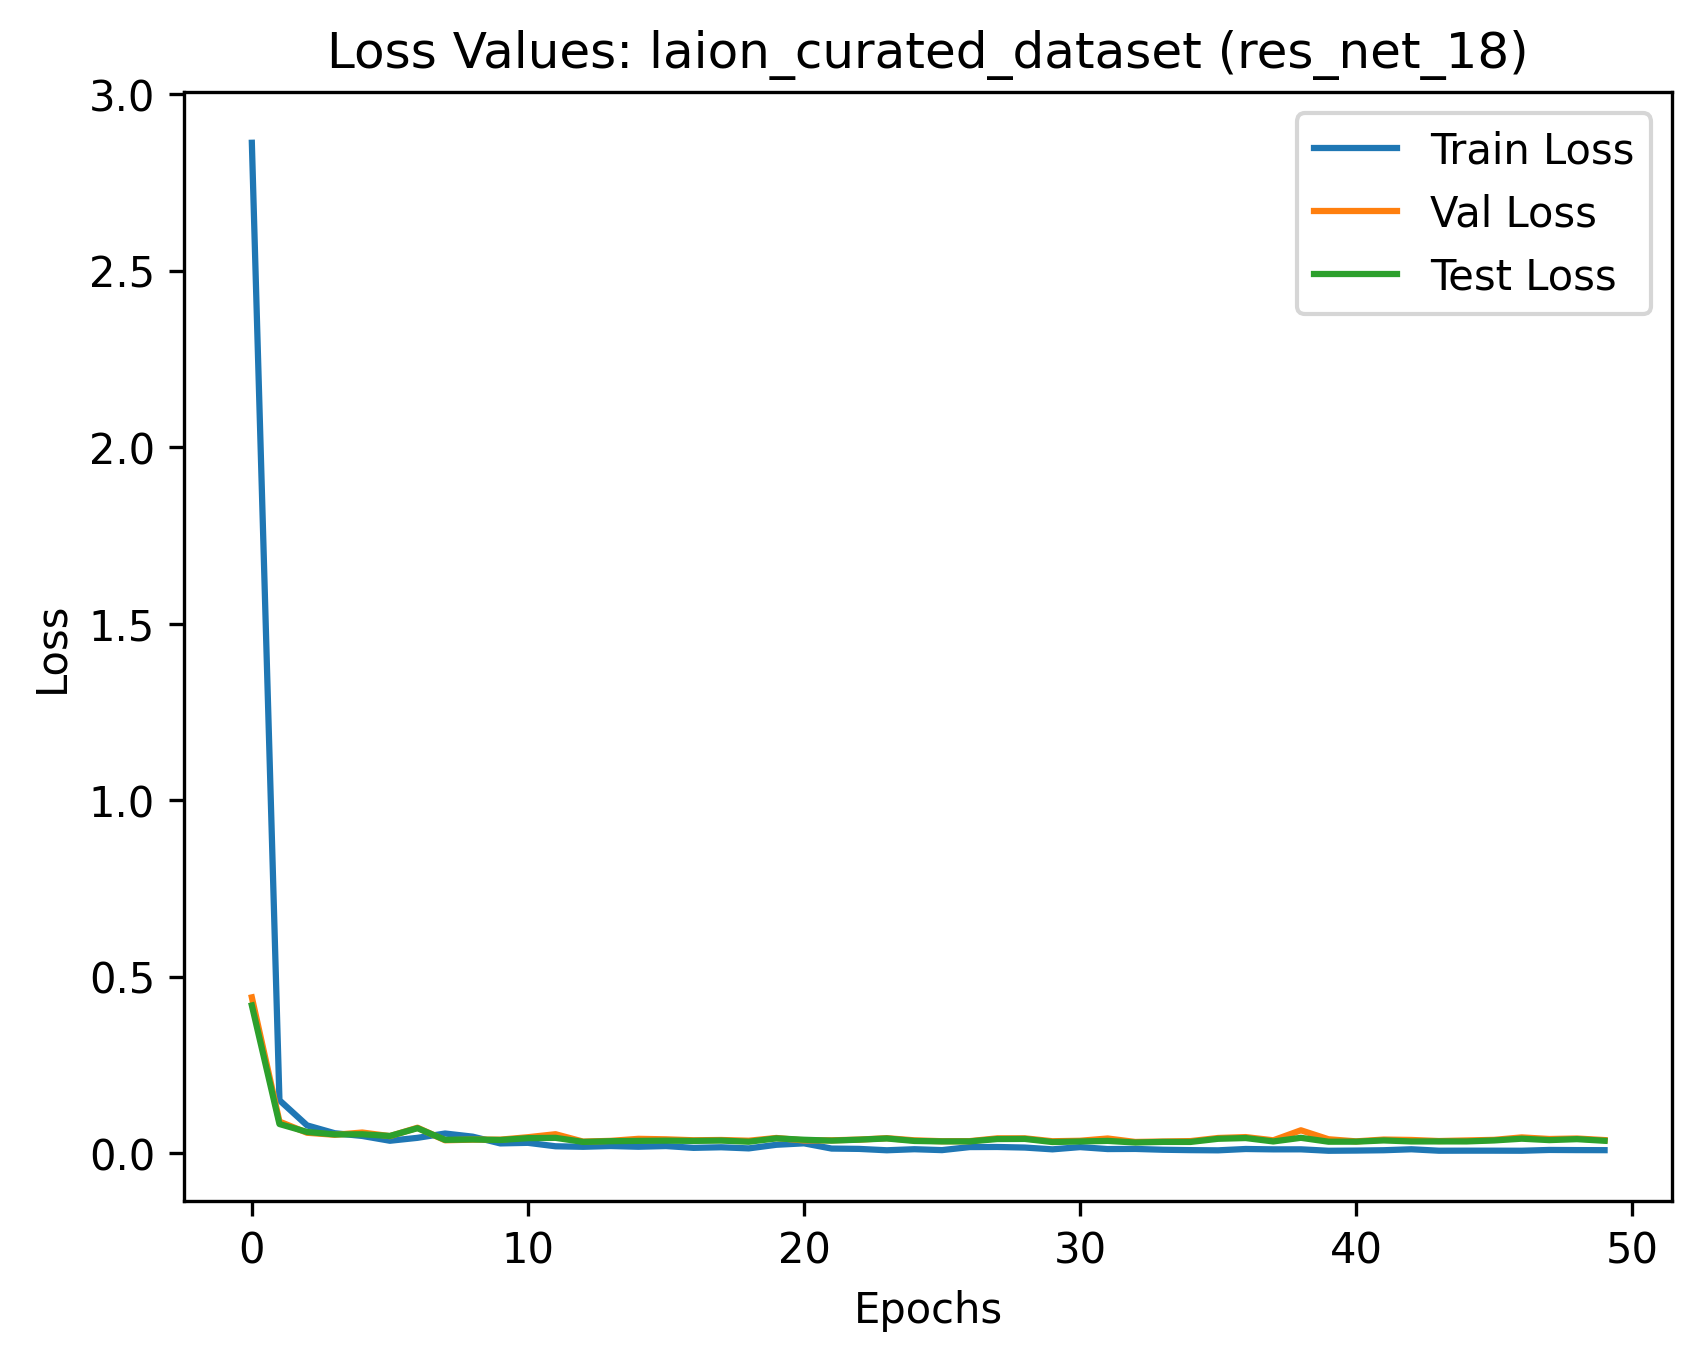

In [ ]:
# res net
laion_model_res_net = run_experiment(dataset_name="laion_curated_dataset",
               url=laion_url,
               data_path=data_path,
               transform=transform,
               epochs=50,
               lr=0.0001,
               model_architecture=RES_NET_18,
               device=device)

In [ ]:
time.sleep(5)

### vgg

data
Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fa828938730>, <torch.utils.data.dataloader.DataLoader object at 0x7fa828939ea0>)
Length train_dataloader: 37
Length test_dataloader: 21
Length test_dataloader: 13


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 1.04373
Validation Loss: 0.62130
Test Loss: 0.68321
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 1
Train Loss: 0.25596
Validation Loss: 0.85246
Test Loss: 0.88459
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 2
Train Loss: 0.17152
Validation Loss: 0.20319
Test Loss: 0.23301
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 3
Train Loss: 0.15490
Validation Loss: 0.19026
Test Loss: 0.21458
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 4
Train Loss: 0.15612
Validation Loss: 0.42452
Test Loss: 0.44450
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 5
Train Loss: 0.16611
Validation Loss: 0.19099
Test Loss: 0.21336
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 6
Train Loss: 0.18511
Validation Loss: 0.21011
Test Loss: 0.22156
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 7
Train Loss: 0.14670
Validation Loss: 0.43728
Test Loss: 0.46391
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 8
Train Loss: 0.12146
Validation Loss: 0.38150
Test Loss: 0.39700
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 9
Train Loss: 0.09826
Validation Loss: 

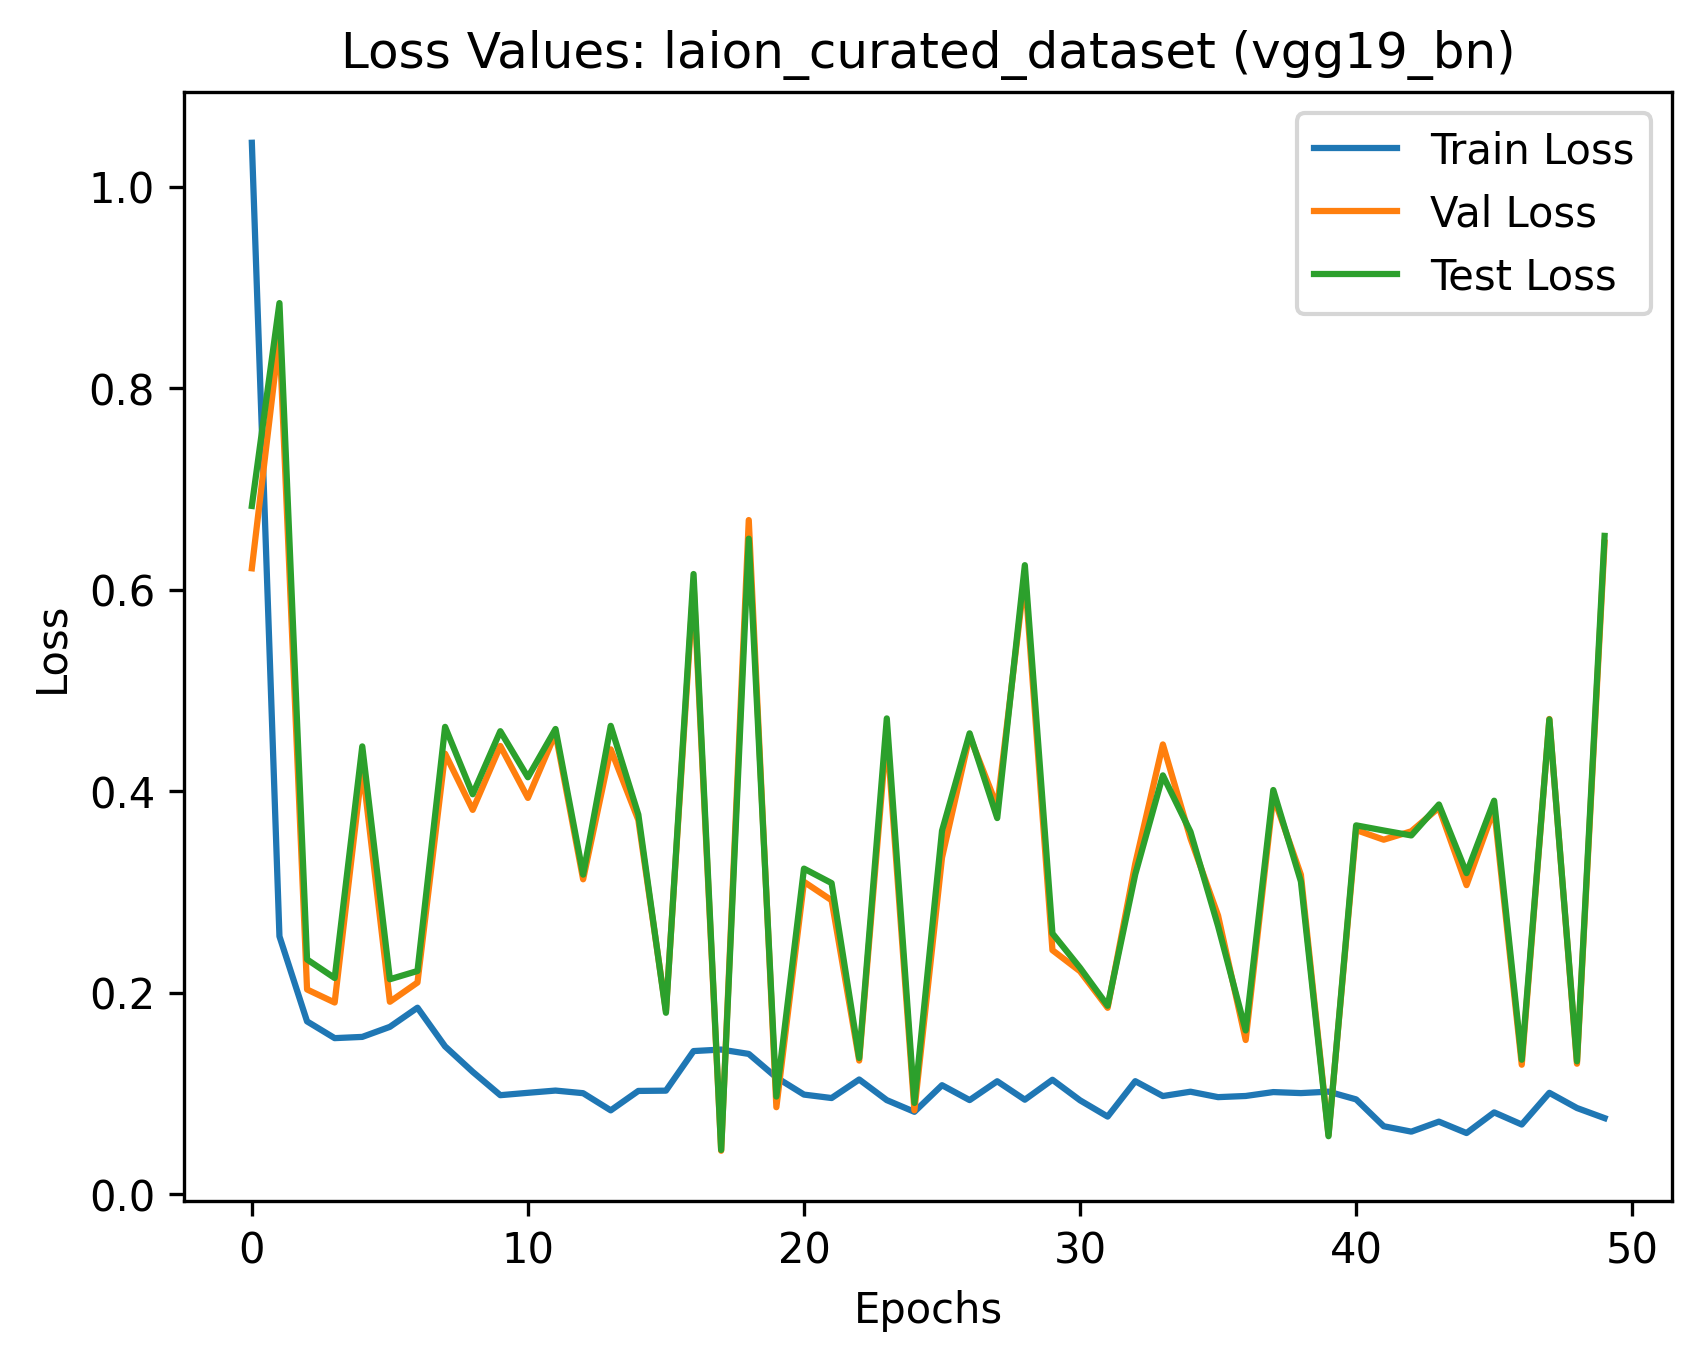

In [ ]:
# vgg
laion_model_vgg = run_experiment(dataset_name="laion_curated_dataset",
               url=laion_url,
               data_path=data_path,
               transform=transform,
               epochs=50,
               lr=0.0001,
               model_architecture=VGG_19,
               device=device)

In [ ]:
time.sleep(5)

## simulacra && laion curated dataset

### dense net

data
Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fa80df09360>, <torch.utils.data.dataloader.DataLoader object at 0x7fa80da86c80>)
Length train_dataloader: 37
Length test_dataloader: 21
Length test_dataloader: 13


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 2.29762
Validation Loss: 0.15425
Test Loss: 0.13360
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 1
Train Loss: 0.10175
Validation Loss: 0.06579
Test Loss: 0.05222
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 2
Train Loss: 0.07552
Validation Loss: 0.04800
Test Loss: 0.03757
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 3
Train Loss: 0.06842
Validation Loss: 0.13945
Test Loss: 0.12261
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 4
Train Loss: 0.03976
Validation Loss: 0.03997
Test Loss: 0.03125
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 5
Train Loss: 0.03666
Validation Loss: 0.04637
Test Loss: 0.03898
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 6
Train Loss: 0.04108
Validation Loss: 0.04257
Test Loss: 0.03367
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 7
Train Loss: 0.03996
Validation Loss: 0.04313
Test Loss: 0.03921
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 8
Train Loss: 0.04010
Validation Loss: 0.06108
Test Loss: 0.06008
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 9
Train Loss: 0.03866
Validation Loss: 

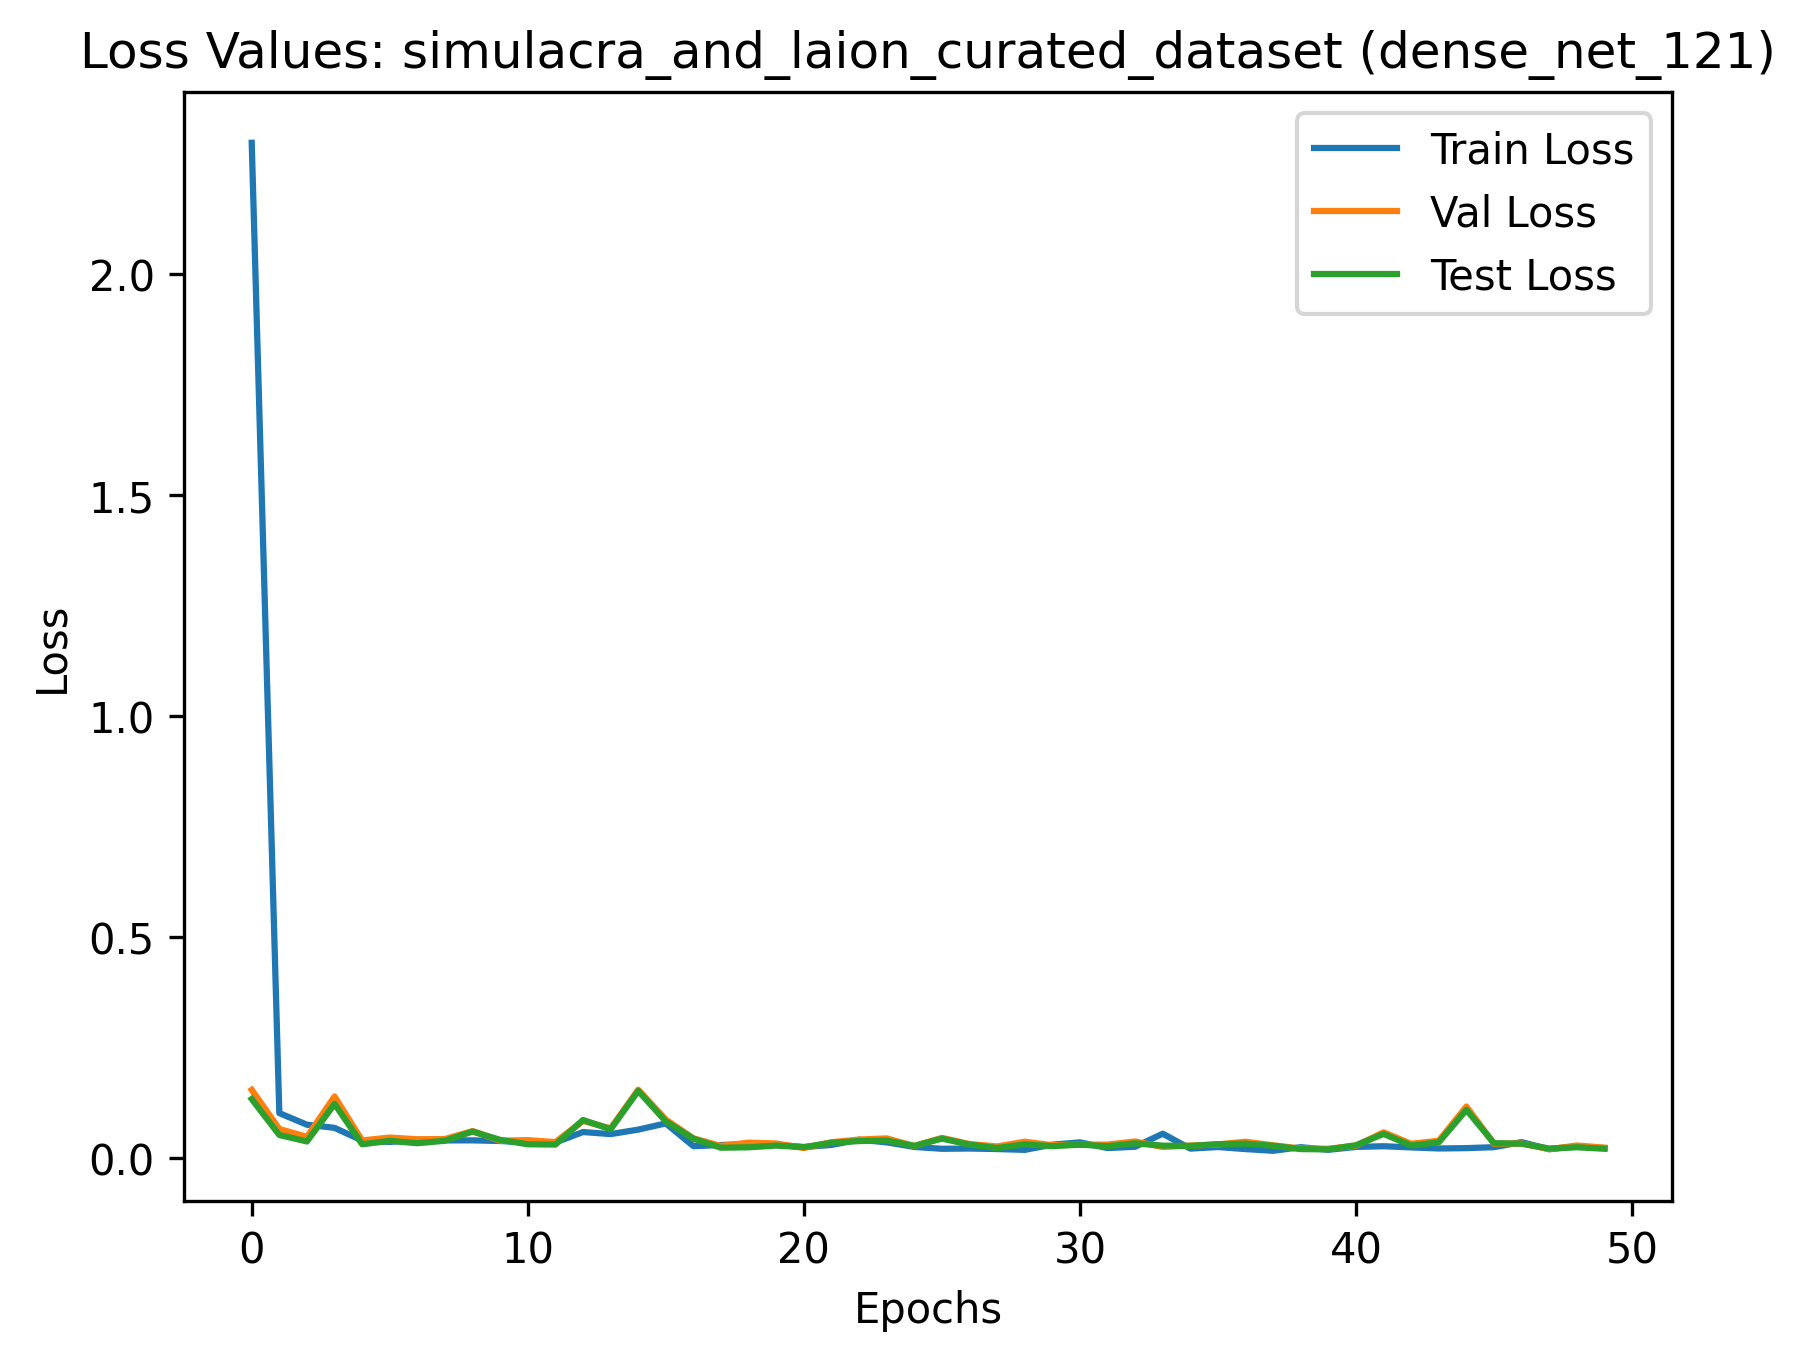

In [ ]:
simulacra_and_laion_model_dense_net = run_experiment(dataset_name="simulacra_and_laion_curated_dataset",
               url=simulacra_and_laion_url,
               data_path=data_path,
               transform=transform,
               epochs=50,
               lr=0.0001,
               model_architecture=DENSE_NET_121,
               device=device)

In [ ]:
time.sleep(5)

### res net

data
Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fa80da51fc0>, <torch.utils.data.dataloader.DataLoader object at 0x7fa80da53b80>)
Length train_dataloader: 37
Length test_dataloader: 21
Length test_dataloader: 13


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 1.74362
Validation Loss: 0.31966
Test Loss: 0.30273
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 1
Train Loss: 0.14176
Validation Loss: 0.05196
Test Loss: 0.05770
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 2
Train Loss: 0.06969
Validation Loss: 0.04533
Test Loss: 0.04944
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 3
Train Loss: 0.04688
Validation Loss: 0.04098
Test Loss: 0.04664
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 4
Train Loss: 0.03636
Validation Loss: 0.04325
Test Loss: 0.04624
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 5
Train Loss: 0.03272
Validation Loss: 0.02735
Test Loss: 0.03339
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 6
Train Loss: 0.02197
Validation Loss: 0.02917
Test Loss: 0.03354
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 7
Train Loss: 0.02393
Validation Loss: 0.02414
Test Loss: 0.03068
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 8
Train Loss: 0.02878
Validation Loss: 0.02712
Test Loss: 0.03071
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 9
Train Loss: 0.02204
Validation Loss: 

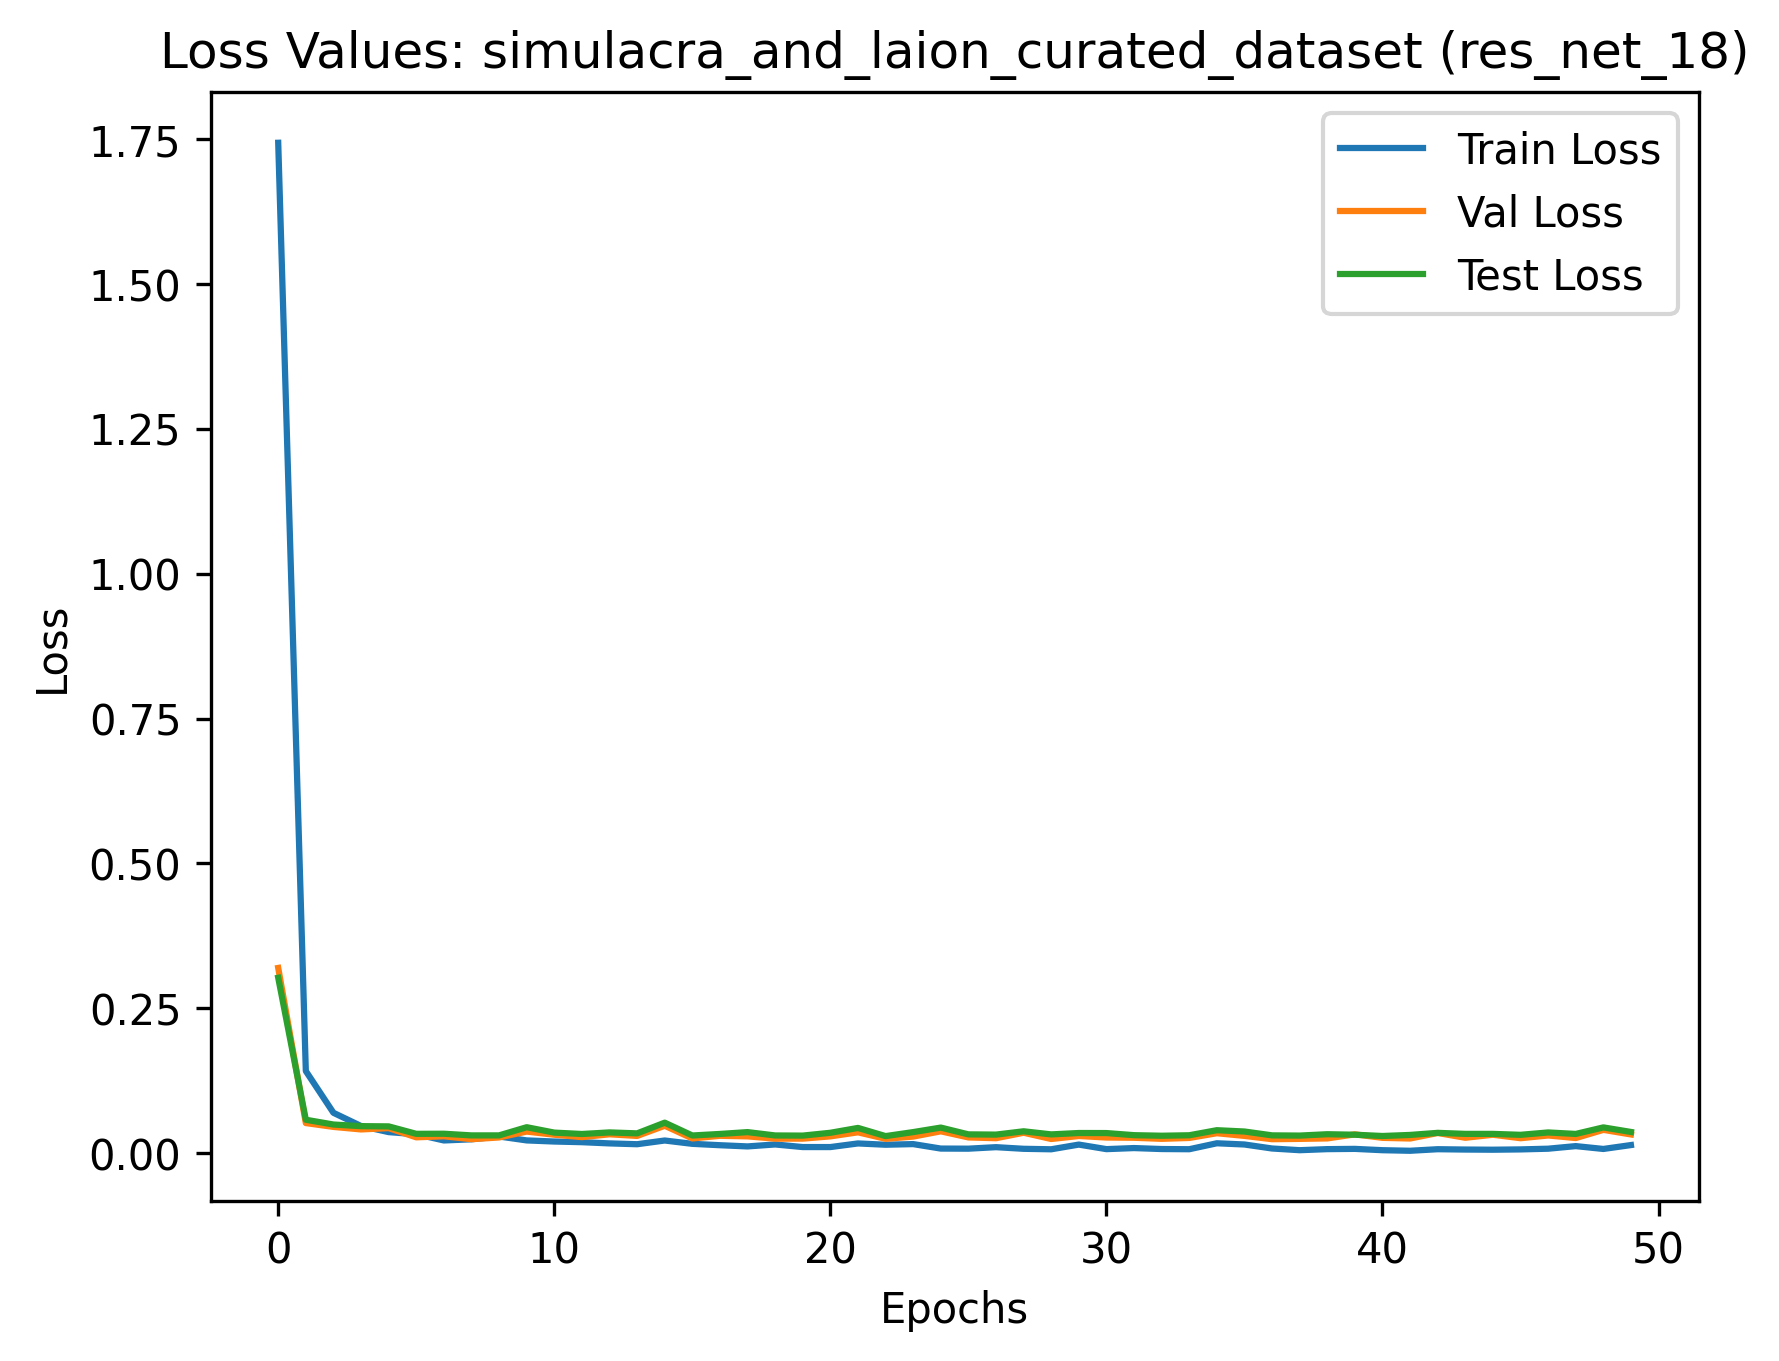

In [ ]:
simulacra_and_laion_model_res_net = run_experiment(dataset_name="simulacra_and_laion_curated_dataset",
               url=simulacra_and_laion_url,
               data_path=data_path,
               transform=transform,
               epochs=50,
               lr=0.0001,
               model_architecture=RES_NET_18,
               device=device)

### vgg

data
Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fa80dc64250>, <torch.utils.data.dataloader.DataLoader object at 0x7fa82899fa30>)
Length train_dataloader: 37
Length test_dataloader: 21
Length test_dataloader: 13


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 1.10074
Validation Loss: 1.52727
Test Loss: 1.54832
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 1
Train Loss: 0.25347
Validation Loss: 0.35165
Test Loss: 0.38906
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 2
Train Loss: 0.23267
Validation Loss: 0.38207
Test Loss: 0.40332
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 3
Train Loss: 0.16385
Validation Loss: 0.55541
Test Loss: 0.59313
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 4
Train Loss: 0.16985
Validation Loss: 0.10630
Test Loss: 0.12275
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 5
Train Loss: 0.15809
Validation Loss: 0.41785
Test Loss: 0.46820
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 6
Train Loss: 0.11749
Validation Loss: 0.82973
Test Loss: 0.85062
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 7
Train Loss: 0.15332
Validation Loss: 0.64155
Test Loss: 0.60626
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 8
Train Loss: 0.19297
Validation Loss: 0.38057
Test Loss: 0.35900
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Epoch: 9
Train Loss: 0.12624
Validation Loss: 

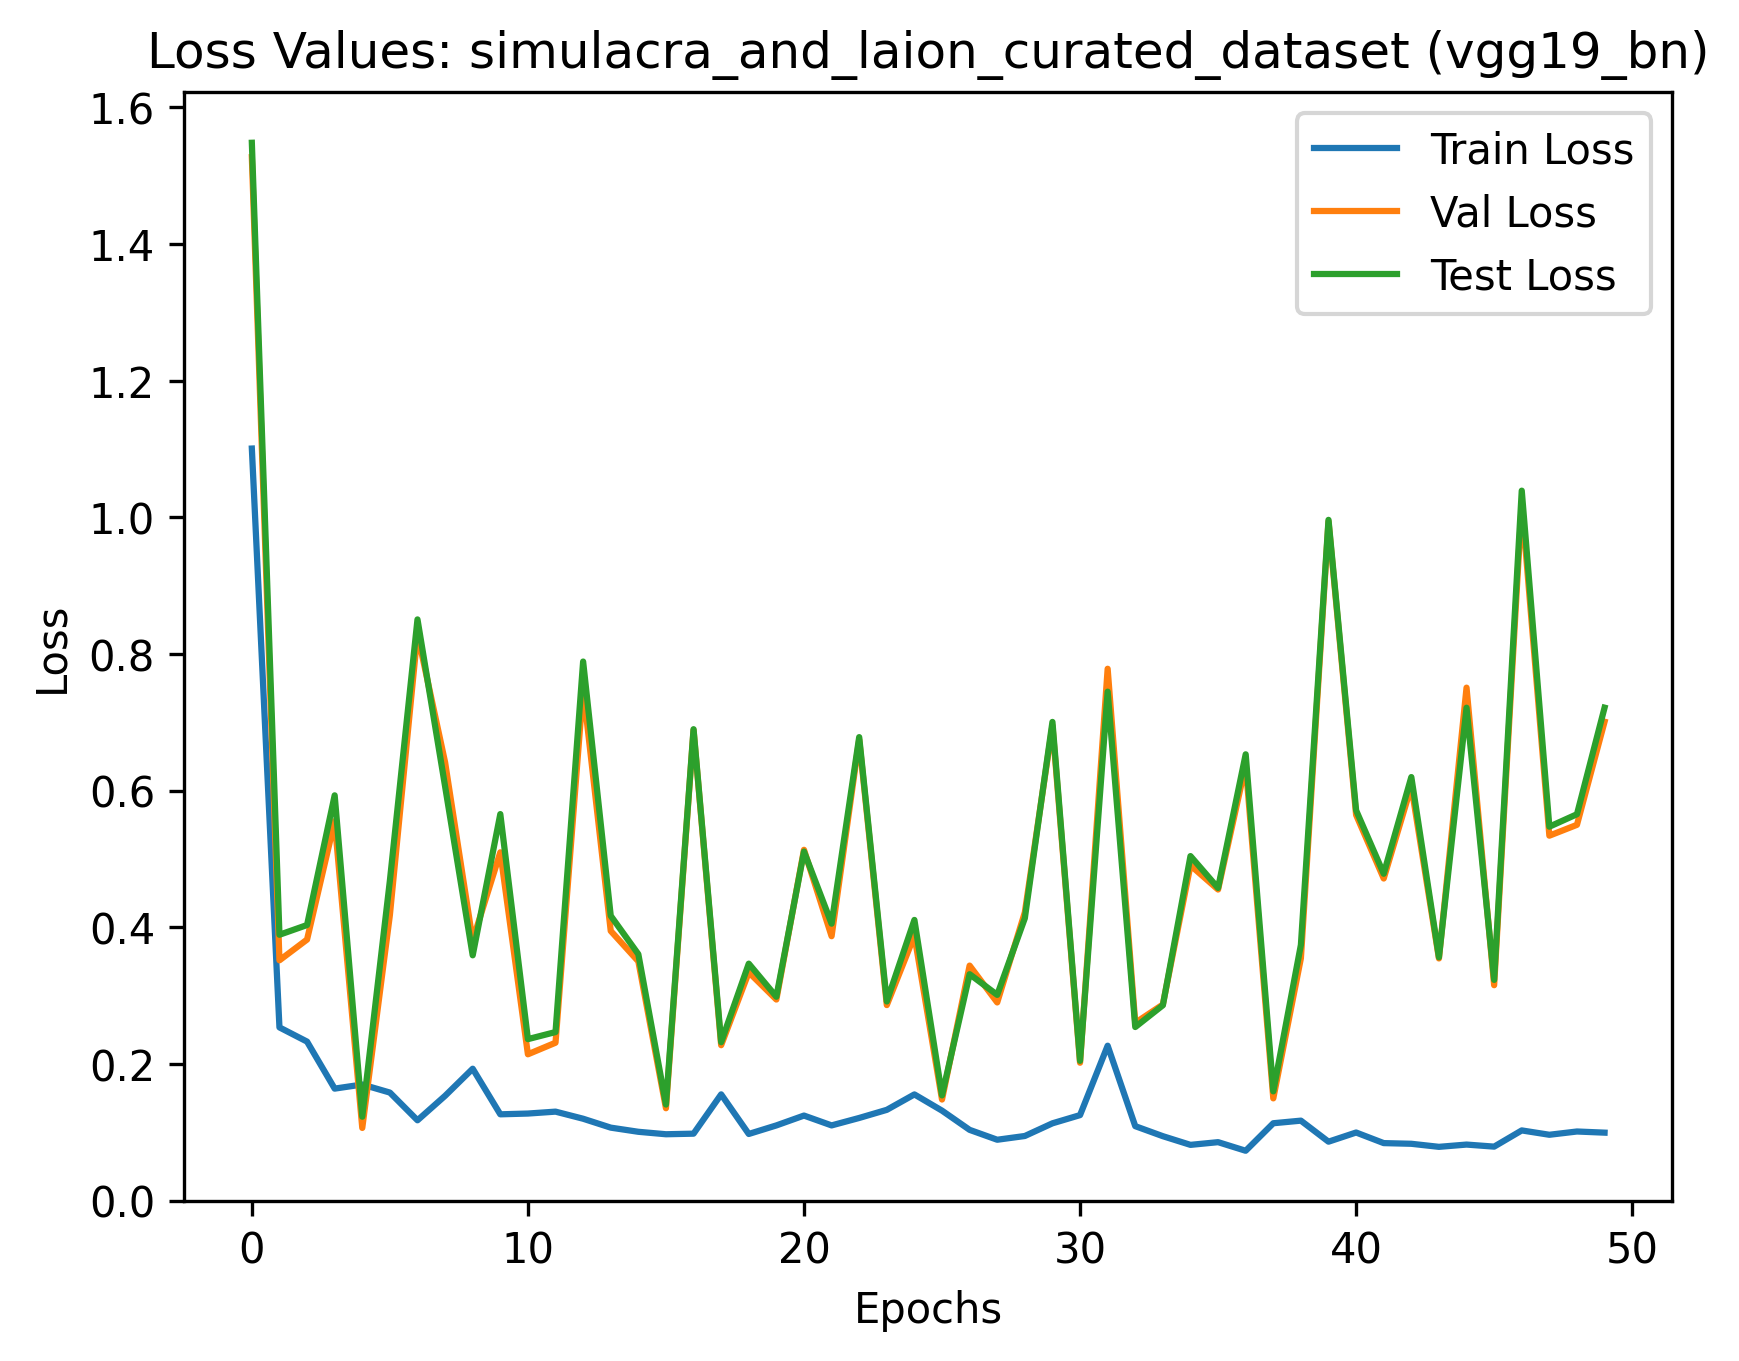

In [ ]:
simulacra_and_laion_model_vgg = run_experiment(dataset_name="simulacra_and_laion_curated_dataset",
               url=simulacra_and_laion_url,
               data_path=data_path,
               transform=transform,
               epochs=50,
               lr=0.0001,
               model_architecture=VGG_19,
               device=device)

In [ ]:
time.sleep(5)

# Pastas com as imagens no tamanho que a rede vai ter como input

In [ ]:
# actualizar as pastas com as imagens no tamanho que a rede vai ter como input , 256x256
from pathlib import Path
from torchvision.utils import save_image

def input_size_folder(folder_name, dataset_name, url, data_path):
  dir = Path(folder_name)

  if dir.is_dir() is False:
    dir.mkdir(parents=True, exist_ok=True)

  # download and extract dataset
  download_dataset(url, data_path, f'{dataset_name}.zip')
  extract_zip_folder(url, data_path)

  images_all, csv_file = get_images_and_csv_file(data_path, dataset_name)

  # create simulacra dataset
  curated_dataset = CustomDataset(image_paths=images_all, transform=transform)

  i = 0
  for data in curated_dataset:
    # normalize
    tensor = (data[0] - data[0].min()) / (data[0].max() - data[0].min())
    name = f'{images_all[i]}'.split('/')[-1]
    save_image(tensor, f'{folder_name}/{name}')
    i = i + 1

In [ ]:
input_size_folder('laion_input_size_256_256', 'laion_curated_dataset', laion_url, data_path)
time.sleep(3)
input_size_folder('simulacra_laion_input_size_256_256', 'simulacra_and_laion_curated_dataset', simulacra_and_laion_url, data_path)
time.sleep(3)
input_size_folder('simulacra_input_size_256_256', 'simulacra_curated_dataset', simulacra_url, data_path)

data
data
data


# Download some folders

In [ ]:
!ls

data		   laion_input_size_256_256  simulacra_input_size_256_256
experiments_plots  models		     simulacra_laion_input_size_256_256


In [ ]:
!zip -r experiments_plots.zip /kaggle/working/experiments_plots/ -q

